## Import

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import json
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans

## Data Loading & Cleaning

### Lines data
This is the stations informaiton, and we will get the stations English translation from here, too.

In [2]:
json_paths = ['tpe_mrt_lines.json', 'newtpe_mrt_lines.json']
line_data = []
for path in json_paths:
     with open(path, 'r') as j:
          line_info = json.loads(j.read())
     line_data += line_info

for line in line_data:
    for station in line["Stations"]:
        station["StationName"]["En"] = station["StationName"]["En"].replace(' ', '_')

### Stations traffic data

In [4]:
df = pd.read_parquet('monthly_data/202306.parquet.gzip')

In [5]:
# df = df.reset_index()
df = df.rename(columns={"時段": "hour", "日期": "date", "進站":"origin", "出站":"destination", "人次":"passenger_cnt"})
df

,date,hour,origin,destination,passenger_cnt
0,2023-06-01,0,松山機場,松山機場,0
1,2023-06-01,0,松山機場,中山國中,0
2,2023-06-01,0,松山機場,南京復興,0
3,2023-06-01,0,松山機場,忠孝復興,0
4,2023-06-01,0,松山機場,大安,1
...,...,...,...,...,...
8096755,2023-06-30,23,新北產業園區,徐匯中學,0
8096756,2023-06-30,23,新北產業園區,三和國中,0
8096757,2023-06-30,23,新北產業園區,三重國小,0
8096758,2023-06-30,23,新北產業園區,迴龍,0


### Mapping English station names

In [6]:
# Mapping Chinese names to English names using the JSON data
chinese_to_english = {}
for line in line_data:
    for station in line["Stations"]:
        chinese_to_english[station["StationName"]["Zh_tw"]] = station["StationName"]["En"]

# Replace Chinese station names with English names
df["origin"] = df["origin"].map(chinese_to_english)
df["destination"] = df["destination"].map(chinese_to_english)

df = df.dropna()
df

,date,hour,origin,destination,passenger_cnt
0,2023-06-01,0,Songshan_Airport,Songshan_Airport,0
1,2023-06-01,0,Songshan_Airport,Zhongshan_Junior_High_School,0
2,2023-06-01,0,Songshan_Airport,Nanjing_Fuxing,0
3,2023-06-01,0,Songshan_Airport,Zhongxiao_Fuxing,0
4,2023-06-01,0,Songshan_Airport,Daan,1
...,...,...,...,...,...
8096755,2023-06-30,23,New_Taipei_Industrial_Park,St.lgnatius_High_School,0
8096756,2023-06-30,23,New_Taipei_Industrial_Park,Sanhe_Junior_High_School,0
8096757,2023-06-30,23,New_Taipei_Industrial_Park,Sanchong_Elementary_School,0
8096758,2023-06-30,23,New_Taipei_Industrial_Park,Huilong,0


In [7]:
df['datetime'] = pd.to_datetime(df['date']) + df['hour'].astype('timedelta64[h]')
df['dayOfWeek'] = df['datetime'].dt.day_name()
df['weekday'] = df['dayOfWeek'].apply(lambda x: 0 if x in ['Saturday', 'Sunday'] else 1)
df

/var/folders/x5/4d64q7td2l59kf73lvykgkq40000gn/T/ipykernel_18387/2225038877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['date']) + df['hour'].astype('timedelta64[h]')
/var/folders/x5/4d64q7td2l59kf73lvykgkq40000gn/T/ipykernel_18387/2225038877.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayOfWeek'] = df['datetime'].dt.day_name()
/var/folders/x5/4d64q7td2l59kf73lvykgkq40000gn/T/ipykernel_18387/2225038877.py:3: SettingWithCopyWarning: 
A value is trying to

,date,hour,origin,destination,passenger_cnt,datetime,dayOfWeek,weekday
0,2023-06-01,0,Songshan_Airport,Songshan_Airport,0,2023-06-01 00:00:00,Thursday,1
1,2023-06-01,0,Songshan_Airport,Zhongshan_Junior_High_School,0,2023-06-01 00:00:00,Thursday,1
2,2023-06-01,0,Songshan_Airport,Nanjing_Fuxing,0,2023-06-01 00:00:00,Thursday,1
3,2023-06-01,0,Songshan_Airport,Zhongxiao_Fuxing,0,2023-06-01 00:00:00,Thursday,1
4,2023-06-01,0,Songshan_Airport,Daan,1,2023-06-01 00:00:00,Thursday,1
...,...,...,...,...,...,...,...,...
8096755,2023-06-30,23,New_Taipei_Industrial_Park,St.lgnatius_High_School,0,2023-06-30 23:00:00,Friday,1
8096756,2023-06-30,23,New_Taipei_Industrial_Park,Sanhe_Junior_High_School,0,2023-06-30 23:00:00,Friday,1
8096757,2023-06-30,23,New_Taipei_Industrial_Park,Sanchong_Elementary_School,0,2023-06-30 23:00:00,Friday,1
8096758,2023-06-30,23,New_Taipei_Industrial_Park,Huilong,0,2023-06-30 23:00:00,Friday,1


## EDA

In [8]:
day_data = df.groupby(['dayOfWeek', 'hour'])['passenger_cnt'].agg('sum').reset_index()
fig = px.line(day_data, x="hour", y="passenger_cnt", facet_col="dayOfWeek")
fig.show()

In [9]:
weekday_data = df.groupby(['weekday', 'hour'])['passenger_cnt'].agg('mean').reset_index()
fig = px.line(weekday_data, x="hour", y="passenger_cnt", facet_col="weekday")
fig.show()

In [10]:
df_weekday = df[df['weekday'] == 1].groupby(['hour','origin'])['passenger_cnt'].agg('mean').reset_index()

# Comment this line to plot all stations
df_weekday_plot = df_weekday[df_weekday['origin'].isin(['Zhongxiao_Fuxing', 'Taipei_City_Hall', 'Xinpu', 'Yongan_Market'])] 
df_weekday_plot['Area'] = ['Business', 'Residence', 'Residence','Business'] * 21

fig = px.line(df_weekday_plot, x="hour", y="passenger_cnt", 
              color='Area', line_group="origin", 
              title='Average Weekday Input by Stations - Specifying Residence/Business Area',
              labels={
                        "passenger_cnt": "Passengers Count",
                        "hour": "Hour",
                    },)
fig.show()

/var/folders/x5/4d64q7td2l59kf73lvykgkq40000gn/T/ipykernel_18387/4068975086.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Modeling

### Task 5: PCA & K-Means

#### Filter weekdays data

In [11]:
df_weekday = df[df['weekday'] == 1]
df_weekday

,date,hour,origin,destination,passenger_cnt,datetime,dayOfWeek,weekday
0,2023-06-01,0,Songshan_Airport,Songshan_Airport,0,2023-06-01 00:00:00,Thursday,1
1,2023-06-01,0,Songshan_Airport,Zhongshan_Junior_High_School,0,2023-06-01 00:00:00,Thursday,1
2,2023-06-01,0,Songshan_Airport,Nanjing_Fuxing,0,2023-06-01 00:00:00,Thursday,1
3,2023-06-01,0,Songshan_Airport,Zhongxiao_Fuxing,0,2023-06-01 00:00:00,Thursday,1
4,2023-06-01,0,Songshan_Airport,Daan,1,2023-06-01 00:00:00,Thursday,1
...,...,...,...,...,...,...,...,...
8096755,2023-06-30,23,New_Taipei_Industrial_Park,St.lgnatius_High_School,0,2023-06-30 23:00:00,Friday,1
8096756,2023-06-30,23,New_Taipei_Industrial_Park,Sanhe_Junior_High_School,0,2023-06-30 23:00:00,Friday,1
8096757,2023-06-30,23,New_Taipei_Industrial_Park,Sanchong_Elementary_School,0,2023-06-30 23:00:00,Friday,1
8096758,2023-06-30,23,New_Taipei_Industrial_Park,Huilong,0,2023-06-30 23:00:00,Friday,1


In [12]:
def create_Y_for_origin_hour(
    data, N, M, origin_mapper, hour_mapper, origin_key="origin", hour_key="hour"
):  # Function to create a dense utility matrix
    data = data.groupby(['origin', 'hour'])['passenger_cnt'].mean().reset_index()
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = origin_mapper[val[origin_key]]
        m = hour_mapper[val[hour_key]]
        Y[n, m] = val["passenger_cnt"]

    return Y

In [13]:
# origin v.s. hour

N = len(df_weekday['origin'].unique())
M = len(df_weekday['hour'].unique())
origin_mapper = dict(zip(np.unique(df_weekday['origin']), list(range(N))))
hour_mapper = dict(zip(np.unique(df_weekday['hour']), list(range(M))))
origin_inverse_mapper = dict(zip(list(range(N)), np.unique(df_weekday['origin'])))
dest_inverse_mapper = dict(zip(list(range(M)), np.unique(df_weekday['hour'])))

utility_mat = create_Y_for_origin_hour(df_weekday,  N, M, origin_mapper, hour_mapper)
utility_mat = utility_mat / utility_mat.sum(axis=1)[:,None]

pd.DataFrame(utility_mat.round(2), index=origin_mapper.keys(), columns=hour_mapper.keys())

,0,1,5,6,7,8,9,10,11,12,...,14,15,16,17,18,19,20,21,22,23
Banxin,0.00,0.0,0.0,0.02,0.09,0.15,0.09,0.04,0.04,0.04,...,0.03,0.04,0.05,0.07,0.12,0.07,0.04,0.03,0.03,0.01
Beimen,0.01,0.0,0.0,0.01,0.05,0.11,0.05,0.03,0.04,0.04,...,0.05,0.05,0.06,0.10,0.14,0.09,0.05,0.04,0.03,0.01
Beitou,0.00,0.0,0.0,0.03,0.10,0.15,0.08,0.06,0.05,0.05,...,0.05,0.04,0.05,0.07,0.08,0.04,0.03,0.03,0.02,0.01
Cailiao,0.00,0.0,0.0,0.03,0.13,0.23,0.11,0.05,0.04,0.04,...,0.03,0.03,0.04,0.06,0.06,0.03,0.02,0.02,0.02,0.01
Chiang_Kai-Shek_Memorial_Hall,0.00,0.0,0.0,0.01,0.03,0.06,0.04,0.03,0.04,0.06,...,0.05,0.05,0.08,0.15,0.15,0.07,0.04,0.05,0.04,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhongxiao_Fuxing,0.01,0.0,0.0,0.00,0.02,0.03,0.02,0.02,0.03,0.04,...,0.05,0.06,0.07,0.09,0.12,0.10,0.09,0.09,0.07,0.03
Zhongxiao_Xinsheng,0.01,0.0,0.0,0.01,0.02,0.05,0.03,0.03,0.03,0.04,...,0.05,0.05,0.07,0.11,0.16,0.10,0.07,0.07,0.05,0.02
Zhongyi,0.00,0.0,0.0,0.02,0.07,0.09,0.05,0.04,0.05,0.05,...,0.04,0.04,0.06,0.10,0.14,0.10,0.05,0.02,0.01,0.01
Zhongyuan,0.00,0.0,0.0,0.01,0.04,0.08,0.04,0.03,0.02,0.03,...,0.02,0.02,0.03,0.08,0.28,0.17,0.05,0.03,0.02,0.01


#### PCA & KMeans

Decide a proper `n_components` by looking at the cumulative explained variance ratio.

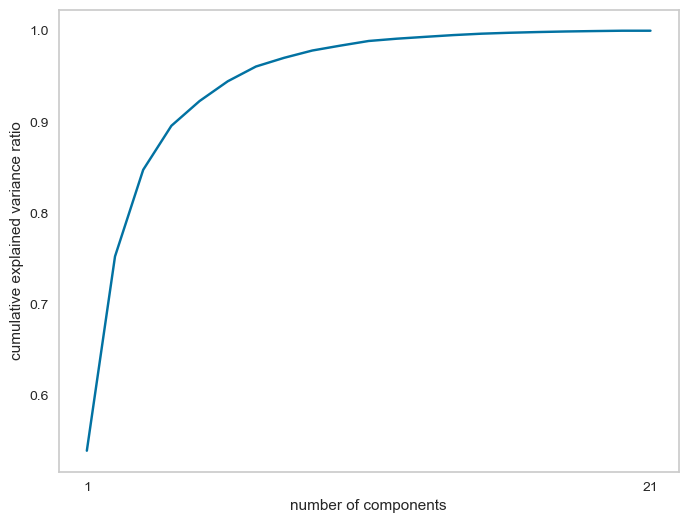

In [14]:
X = utility_mat
n_components = 21


X = StandardScaler().fit_transform(X)

pca = PCA(n_components=n_components, whiten=True, random_state=0)
pca.fit(X)

plt.figure(figsize=(8, 6))
plt.plot(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(1, n_components+1, 20))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance ratio")
plt.grid();
plt.show()


In [17]:
n_components = 3
pca = PCA(n_components=n_components)

X_tran = StandardScaler().fit_transform(X)
pca.fit(X_tran)

PCA(n_components=3)

When looking at the $W$ matrix below, we can identify that :
- PC_1 is night hours
- PC_2 is noon hours
- PC_3 is morning hours

In [18]:
pd.set_option('precision', 2)

W = pca.components_
W_df = pd.DataFrame(W, columns=hour_mapper.keys(), index=[f'PC_{i}' for i in range(1,n_components+1)])
W_df.round(2).style.background_gradient(cmap='Blues')

,0,1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
PC_1,0.22,0.18,-0.04,-0.26,-0.28,-0.28,-0.29,-0.28,-0.21,-0.09,-0.07,0.08,0.15,0.15,0.22,0.23,0.24,0.28,0.27,0.25,0.23
PC_2,0.04,0.14,0.05,-0.01,-0.06,-0.07,-0.02,0.12,0.29,0.41,0.43,0.42,0.37,0.31,0.15,-0.19,-0.21,-0.06,0.04,0.05,0.02
PC_3,0.42,0.30,0.08,0.19,0.14,0.14,0.14,0.10,-0.04,-0.12,0.04,0.03,-0.03,-0.25,-0.35,-0.28,-0.17,0.09,0.23,0.30,0.40


In [19]:
Z = pca.fit_transform(X)

Z_df = pd.DataFrame(Z, index=origin_mapper.keys(), columns=['Night', 'Noon', 'Morning'])[['Morning', 'Noon', 'Night']]
Z_df = Z_df.loc[['Zhongxiao_Fuxing', 'Taipei_City_Hall', 'Xinpu', 'Yongan_Market'], :]
Z_df.style.background_gradient(cmap='Blues', axis=1)

,Morning,Noon,Night
Zhongxiao_Fuxing,2.84,1.77,6.95
Taipei_City_Hall,1.38,-1.04,6.19
Xinpu,0.68,-0.22,-3.44
Yongan_Market,0.73,-0.32,-4.14


In [20]:
X_trans = Z @ W

kmeans = KMeans(n_clusters=3)
kmeans.fit(Z)
clust_labels = kmeans.labels_

clust_df = pd.DataFrame(X_trans, index=origin_mapper.keys(), columns=hour_mapper.keys())
clust_df['labels'] = clust_labels

In [21]:
clust_df

,0,1,5,6,7,8,9,10,11,12,...,15,16,17,18,19,20,21,22,23,labels
Banxin,-0.15,-0.32,-0.04,0.22,0.31,0.33,0.24,-0.02,-0.39,-0.67,...,-0.74,-0.68,-0.47,0.14,0.18,-0.06,-0.22,-0.21,-0.12,1
Beimen,0.75,0.69,-0.03,-0.60,-0.72,-0.72,-0.69,-0.56,-0.28,0.08,...,0.68,0.55,0.56,0.32,0.36,0.70,0.81,0.80,0.75,2
Beitou,-0.57,-0.24,0.18,0.61,0.59,0.56,0.68,0.93,1.12,1.05,...,0.35,0.27,-0.20,-0.93,-1.00,-0.87,-0.65,-0.60,-0.64,1
Cailiao,-0.39,-0.46,0.15,1.02,1.10,1.10,1.06,0.85,0.34,-0.23,...,-0.87,-1.01,-1.17,-0.80,-0.71,-0.77,-0.72,-0.60,-0.42,1
Chiang_Kai-Shek_Memorial_Hall,-0.13,0.23,-0.17,-1.20,-1.25,-1.28,-1.16,-0.72,0.17,0.96,...,1.35,1.69,1.73,0.80,0.56,0.49,0.42,0.23,-0.12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zhongxiao_Fuxing,2.79,2.36,0.02,-1.28,-1.68,-1.66,-1.64,-1.43,-1.01,-0.25,...,1.59,0.85,0.81,0.46,0.80,2.12,2.59,2.71,2.78,0
Zhongxiao_Xinsheng,1.45,1.26,-0.11,-1.20,-1.40,-1.40,-1.39,-1.22,-0.79,-0.14,...,1.08,0.88,1.03,0.80,0.90,1.44,1.57,1.54,1.47,0
Zhongyi,-0.82,-0.55,-0.13,-0.36,-0.27,-0.28,-0.25,-0.12,0.19,0.39,...,0.17,0.60,0.72,0.46,0.24,-0.23,-0.45,-0.59,-0.80,2
Zhongyuan,-0.66,-1.03,-0.53,-1.00,-0.68,-0.62,-0.91,-1.53,-1.99,-2.10,...,-1.55,-0.71,0.51,2.25,2.10,0.78,-0.12,-0.40,-0.47,0


#### Viz

In [22]:
def visualizing_results(Z, label):
    pca_df = pd.DataFrame(Z, columns=['PC1', 'PC2', 'PC3'], index=origin_mapper.keys()).reset_index()
    pca_df['label'] = label
    pca_df['label'] = pca_df['label'].astype(str)

    fig = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', 
                     color='label', 
                     hover_data={"origin": (pca_df['index'])},
                     labels={
                        "PC1": "Night",
                        "PC2": "Noon",
                        "PC3": "Morning",
                    },
                     opacity=0.7,
                    size_max=1,
                     width = 700, height = 500
                     ).update_layout(margin=dict(l=0, r=0, b=0, t=0)
                    ).update_traces(marker_size = 5)
    
    fig.show()


visualizing_results(Z, kmeans.labels_)


In [24]:
df_weekday = df[df['weekday'] == 1].groupby(['hour','origin'])['passenger_cnt'].agg('mean').reset_index()

# Comment this line to plot all stations
label_mapper = {k: l for k, l in zip(origin_mapper.keys(), kmeans.labels_)}
df_weekday['Cluster'] = df_weekday['origin'].apply(lambda x : label_mapper[x])

fig = px.line(df_weekday, x="hour", y="passenger_cnt", 
              color='Cluster', line_group="origin", facet_col="Cluster",
              title='Average Weekday Input of Each Station - By Cluster',
              labels={
                        "passenger_cnt": "Passengers Count",
                        "hour": "Hour",
                    },)
fig.show()

This plot is for illustration in the Medium article.

In [25]:
cluster1_plot = df_weekday[df_weekday['origin'].isin(['Taipei_Main_Station', 'Taipei_Zoo'])] 
fig = px.line(cluster1_plot, x="hour", y="passenger_cnt", 
              color='origin',
              title='Extreme Cases in Cluster 1 - Taipei Main Station v.s.  Taipei Zoo',
              labels={
                        "passenger_cnt": "Passengers Count",
                        "hour": "Hour",
                    },
                width=800
            )
fig.show()